In [153]:
import pandas as pd
import seaborn as sns
from pylab import *
%matplotlib inline  # plot figure inline
%config InlineBackend.figure_format = 'retina'  # high resolution inline figure

#Read table 

In [154]:
usecols = ["Mutationid", "Refseq", "Genesymbol", "miRNA",
           "Targetsiteclass", "Cancertype", "Targetscan", "wildtype_csp", "mutant_csp",
           "pita_ref", "pita_mut"]
df = pd.read_table("target_somatic.txt.gz", compression='gzip', usecols=usecols)
print df.shape

(565953, 11)


In [155]:
genes = sorted(set(df["Genesymbol"].values))[1:]  # exclude nan
miRs = sorted(set(df["miRNA"].values))[1:]  # exclude nan
print "Total", len(miRs), "miRNAs"
print "Total", len(genes), "genes"

Total 1921 miRNAs
Total 8375 genes


#Select prediction method: TargetScan or Pita

In [156]:
#prefix = 'pita'
prefix = 'targetscan'

In [157]:
if prefix == "pita":
    df = df.dropna(subset=["pita_ref", "pita_mut"])
    df["diff"] = df["pita_ref"] - df["pita_mut"]
elif prefix == "targetscan":
    df = df[df["Targetscan"] == 1]
    df.replace("no TS", 0, inplace=True)
    df.fillna(0, inplace=True)
    df["diff"] = df["wildtype_csp"].astype(float) - df["mutant_csp"].astype(float)
else:
    print "Unsupported method!"
print df.shape

(113691, 12)


#Degree profiles

Prepare output in-/out-degree dataframes.

In [158]:
indeg_df = pd.DataFrame(index=genes)
outdeg_df = pd.DataFrame(index=miRs)
print indeg_df.shape
print outdeg_df.shape

(8375, 0)
(1921, 0)


Pivot the mutation table to compute the in-/out-degree tables.

In [159]:
for cancer in set(df["Cancertype"].values):
    test = df[df["Cancertype"] == cancer]
    #if "TCGA" in cancer:
    #    continue
    if test.shape[0] < 500:  # filter out those cancer types with too few rewiring events
        continue
    print cancer, test.shape, "->",
    
    # pivoting 
    t1 = test.pivot_table(index=["Genesymbol", "Mutationid"], columns="miRNA", values="diff").fillna(0)
    t2 = t1.groupby(level="Genesymbol").sum()  # gene x miRNA: delta regulation score
    outdeg_df[cancer] = t2.sum(axis=0)
    indeg_df[cancer] = t2.sum(axis=1)
    print t2.shape, "->",
    
    # pca 
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_new = pca.fit_transform(t2.T)  # PCA on t2.T and then get transformed X_new
    print X_new.shape
    figure()
    plot(X_new[:,0], X_new[:,1], 'o')
    xlabel('PC1: %.1f%%' % (pca.explained_variance_ratio_[0] * 100))
    ylabel('PC2: %.1f%%' % (pca.explained_variance_ratio_[1] * 100))
    savefig("pca/%s.png" % cancer.replace("/", "_"))
    close()

BreastCarcinoma(WTSI,UK) (800, 12) -> (111, 408) -> (408, 2)
Melanoma (1330, 12) -> (185, 575) -> (575, 2)
Leukemia/T-ALL (685, 12) -> (27, 191) -> (191, 2)
BladderUrothelialCarcinoma(TCGA,US) (714, 12) -> (112, 449) -> (449, 2)
GastricCancer(CCGC,CN) (1238, 12) -> (167, 582) -> (582, 2)
Colorectal adenocarcinoma (3728, 12) -> (588, 1129) -> (1129, 2)
LiverCancer(NCC,JP) (28048, 12) -> (3362, 1898) -> (1898, 2)
Small cell lung cancer (541, 12) -> (67, 246) -> (246, 2)
Breast Cancer (2328, 12) -> (325, 827) -> (827, 2)
RectumAdenocarcinoma(TCGA,US) (647, 12) -> (18, 193) -> (193, 2)
Medulloblastoma (1517, 12) -> (225, 643) -> (643, 2)
Hypodiploid_ALL (1124, 12) -> (146, 526) -> (526, 2)
Prostate (934, 12) -> (144, 450) -> (450, 2)
ColonAdenocarcinoma(TCGA,US) (3420, 12) -> (180, 948) -> (948, 2)
LiverCancer(RIKEN,JP) (24157, 12) -> (2760, 1854) -> (1854, 2)
Lung (2141, 12) -> (284, 767) -> (767, 2)
UterineCorpusEndometrioidCarcinoma(TCGA,US) (7796, 12) -> (739, 1650) -> (1650, 2)
Prosta

Fillna & zscore

In [160]:
indeg_df.fillna(0, inplace=True)
outdeg_df.fillna(0, inplace=True)

In [161]:
from scipy.stats import zscore
t1 = indeg_df.apply(zscore)
t2 = outdeg_df.apply(zscore)

Output the tables

In [162]:
t1.to_csv("%s_indeg_zscore.tsv" % prefix, sep="\t")
t2.to_csv("%s_outdeg_zscore.tsv" % prefix, sep="\t")

#Cancer gene lists

In [163]:
FILE1 = "cancer_genes/allonco_20130923.tsv"
FILE2 = "cancer_genes/CCGD_export.csv"
FILE3 = "cancer_genes/Human_716_TSGs.txt"
FILE4 = "cancer_genes/oncogenes.txt"
FILE5 = "cancer_genes/intogen.txt"
FILE6 = "cancer_genes/oncomir.txt"

L1 = set(pd.read_table(FILE1)["symbol"]) & set(genes)
L2 = set(pd.read_csv(FILE2)["Human Symbol"]) & set(genes)
L3 = set(pd.read_table(FILE3)["GeneID"]) & set(genes)
L4 = {i.strip() for i in open(FILE4)} & set(genes)
L5 = {i.strip() for i in open(FILE5)} & set(genes)
L6 = {i.strip() for i in open(FILE6)} & set(miRs)

print len(L1)
print len(L2)
print len(L3)
print len(L4)
print len(L5)
print len(L6)

977
3290
336
253
265
263


#PCA

(18, 2)
[-9.6524677  -6.91086568] 	BreastCarcinoma(WTSI,UK)
[ 1.85598991  3.69786103] 	Melanoma
[ 8.90136164  8.37749994] 	Leukemia/T-ALL
[ 2.47089676  6.28059371] 	BladderUrothelialCarcinoma(TCGA,US)
[ 3.90910266 -4.48463918] 	GastricCancer(CCGC,CN)
[-1.31730556  0.54931279] 	Colorectal adenocarcinoma
[ 1.16686678  1.05160613] 	LiverCancer(NCC,JP)
[ -3.35902162 -12.29787276] 	Small cell lung cancer
[-1.16141229 -0.88630895] 	Breast Cancer
[-11.88021275   9.91430481] 	RectumAdenocarcinoma(TCGA,US)
[ 3.9837287   1.67872439] 	Medulloblastoma
[ 1.09745133 -0.31637448] 	Hypodiploid_ALL
[-0.44590427 -1.11264247] 	Prostate
[-6.61850381  4.1995952 ] 	ColonAdenocarcinoma(TCGA,US)
[ 1.38774632 -0.2505217 ] 	LiverCancer(RIKEN,JP)
[ 0.43285945 -2.34141783] 	Lung
[-1.44391022 -2.26390003] 	UterineCorpusEndometrioidCarcinoma(TCGA,US)
[ 10.67273466  -4.8849549 ] 	ProstateCancer(OICR,CA)


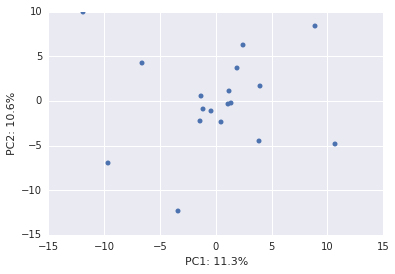

In [164]:
pca = PCA(n_components=2)
#X_new = pca.fit_transform(t1.loc[L5].T)  # cancer gene list L1-L5
X_new = pca.fit_transform(t2.loc[L6].T)  # oncomir list L6
print X_new.shape
plot(X_new[:,0], X_new[:,1], 'o', ms=5)
xlabel('PC1: %.1f%%' % (pca.explained_variance_ratio_[0] * 100))
ylabel('PC2: %.1f%%' % (pca.explained_variance_ratio_[1] * 100))

for i,x in enumerate(t2.columns):
    print X_new[i], '\t', x

#Heatmaps

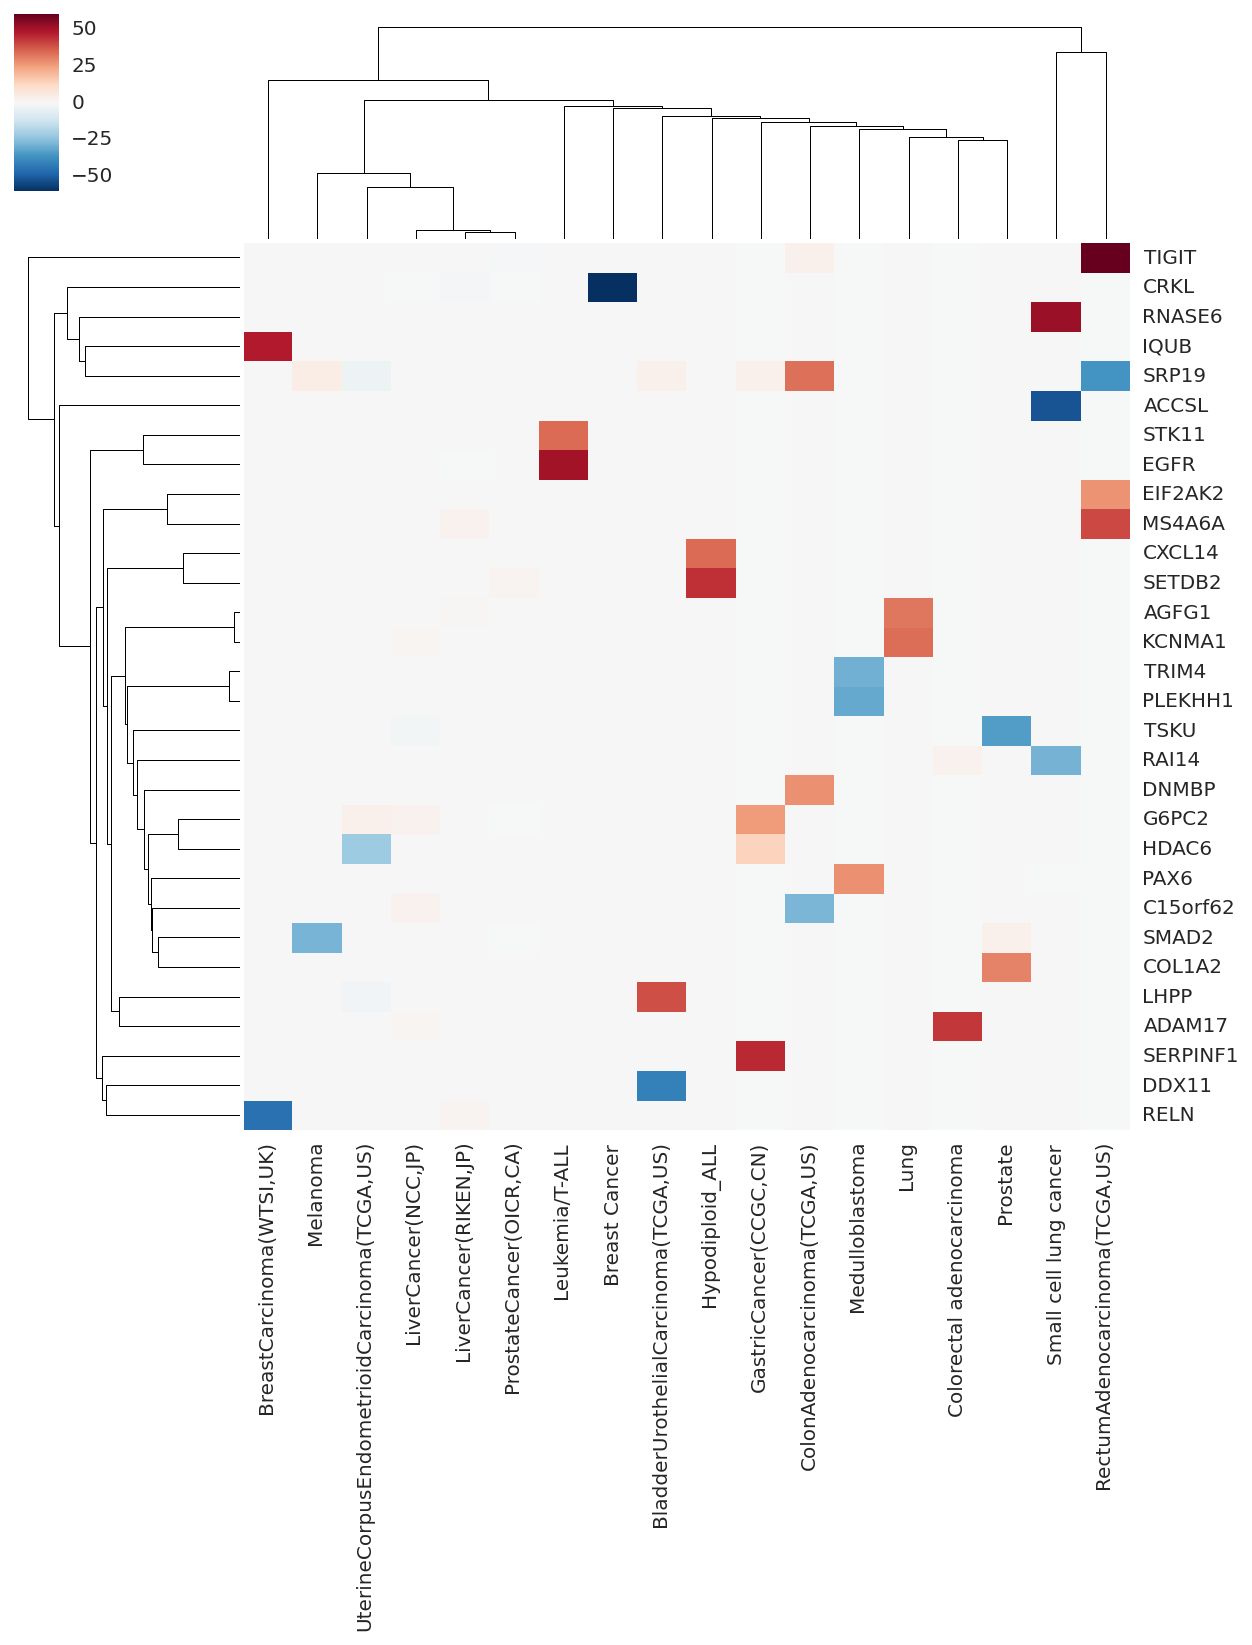

In [271]:
foo = t1.loc[t1.var(axis=1).sort(inplace=False)[-30:].index]
#foo = t1.loc[L5]
#foo = t1
sns.clustermap(foo)
savefig("%s_indeg_zscore.heatmap.png" % prefix, dpi=300)

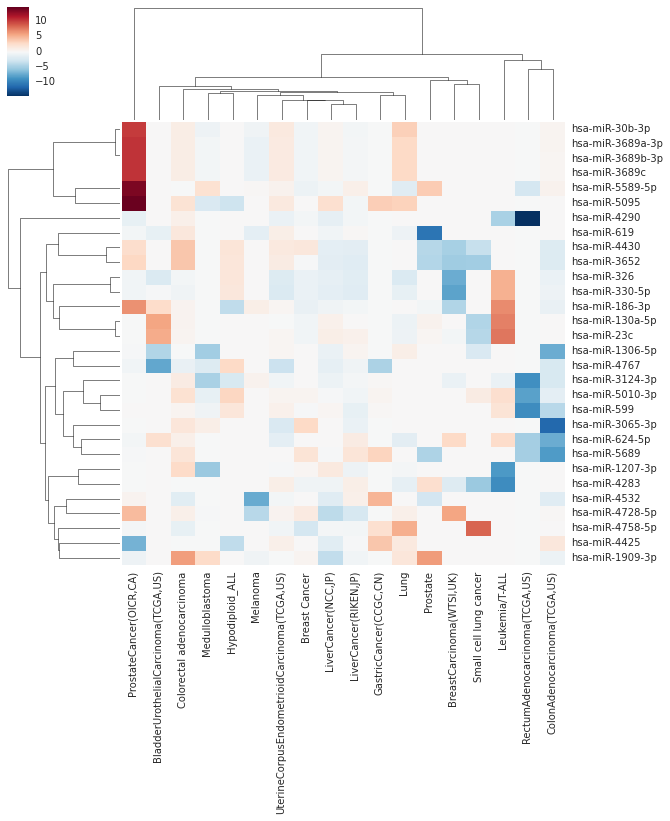

In [166]:
bar = t2.loc[t2.var(axis=1).sort(inplace=False)[-30:].index]
#bar = t2.loc[L6]
#bar = t2
sns.clustermap(bar)
savefig("%s_outdeg_zscore.heatmap.png" % prefix, dpi=300)

#Fisher's exact test for overrepresentation of cancer genes

In [222]:
def fisher_2d(a,b,c,d,verbose=False):
    """Fisher's exact test by contigency 2D table:
    a     (b-a)    b
    (c-a) (d-b-c+a)        
    c              d
    """
    from scipy.stats import fisher_exact
    oddsratio, p_value = fisher_exact([[a, b-a], [c-a, d-b-c+a]])
    if verbose:
        print "%d/%d = %d%%" % (a, b, 100. * a / b)
        print "Odds ratio: %.2f" % oddsratio
        print "P-value: %.2e" % p_value
    return 100. * a / b, oddsratio, p_value

def fisher_exact_test(genelist, geneset, n_background):
    a = len(genelist & geneset)
    b = len(genelist)
    c = len(geneset)
    d = n_background
    return fisher_2d(a,b,c,d,True)
    

In [269]:
def overrepresented_cancer_genes(df, genelist, n_background):
    logp = []
    pcts = []
    for col in df:
        print col
        pos = set(df[df[col] >= 2].index)
        neg = set(df[df[col] <= -2].index)
        pct, odds, pval = fisher_exact_test(pos | neg, genelist, n_background)
        pcts.append(pct)
        logp.append(-log10(pval))
        print
    #figure(figsize=(6,12))
    plt.barh(range(df.shape[1]), logp)
    plt.axvline(2, color='crimson', ls='dashed', lw=0.5)
    ax = gca()
    # add some text for labels, title and axes ticks
    ax.set_xlabel('-log10(P)')
    ax.set_title('Enrichment of cancer genes')
    ax.set_yticklabels(df.columns)
    ax.set_yticks(arange(df.shape[1])+0.5)
    savefig("Enrichment_of_cancer_genes.png", dpi=300)

In [187]:
L1 = set(pd.read_table(FILE1)["symbol"])
L2 = set(pd.read_csv(FILE2)["Human Symbol"])
L3 = set(pd.read_table(FILE3)["GeneID"])
L4 = {i.strip() for i in open(FILE4)}
L5 = {i.strip() for i in open(FILE5)}

BreastCarcinoma(WTSI,UK)
9/64 = 14%
Odds ratio: 1.22
P-value: 5.60e-01

Melanoma
14/141 = 9%
Odds ratio: 0.82
P-value: 6.00e-01

Leukemia/T-ALL
24/24 = 100%
Odds ratio: inf
P-value: 5.01e-23

BladderUrothelialCarcinoma(TCGA,US)
12/78 = 15%
Odds ratio: 1.36
P-value: 2.95e-01

GastricCancer(CCGC,CN)
18/112 = 16%
Odds ratio: 1.43
P-value: 1.84e-01

Colorectal adenocarcinoma
25/206 = 12%
Odds ratio: 1.03
P-value: 8.29e-01

LiverCancer(NCC,JP)
50/456 = 10%
Odds ratio: 0.92
P-value: 6.07e-01

Small cell lung cancer
6/39 = 15%
Odds ratio: 1.36
P-value: 4.56e-01

Breast Cancer
21/141 = 14%
Odds ratio: 1.31
P-value: 2.40e-01

RectumAdenocarcinoma(TCGA,US)
2/15 = 13%
Odds ratio: 1.15
P-value: 6.95e-01

Medulloblastoma
14/114 = 12%
Odds ratio: 1.04
P-value: 8.84e-01

Hypodiploid_ALL
16/101 = 15%
Odds ratio: 1.41
P-value: 2.15e-01

Prostate
16/94 = 17%
Odds ratio: 1.53
P-value: 1.46e-01

ColonAdenocarcinoma(TCGA,US)
9/99 = 9%
Odds ratio: 0.74
P-value: 5.31e-01

LiverCancer(RIKEN,JP)
65/445 = 14%
O

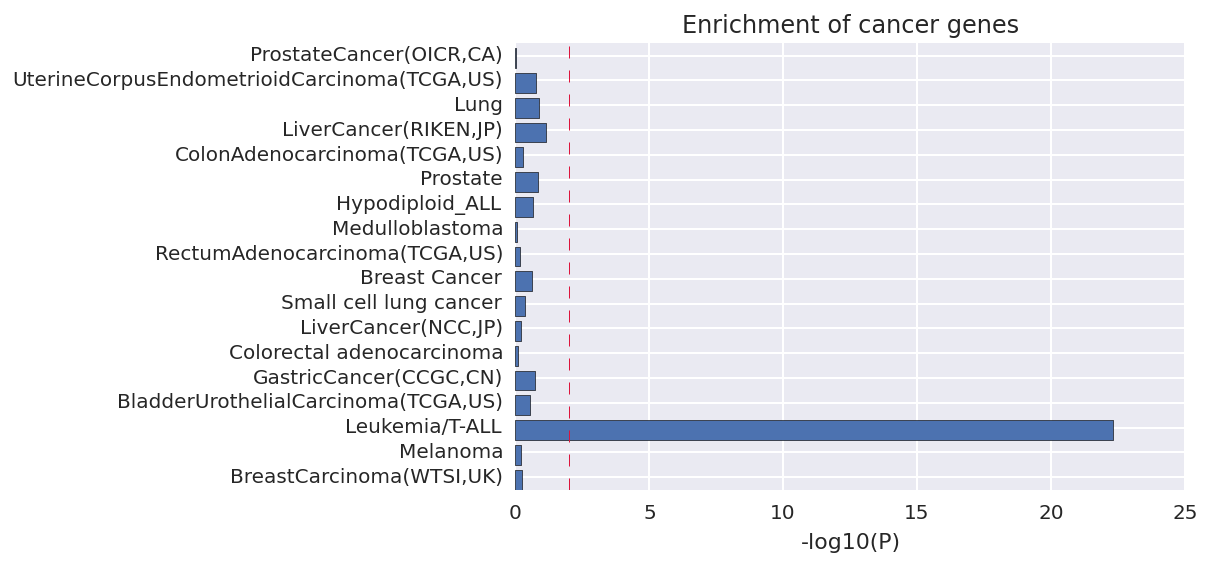

In [270]:
overrepresented_cancer_genes(t1, L1, 18000)  # Resutls of L1,2,3,4,5 are quite similar

In [205]:
L6 = {i.strip() for i in open(FILE6)}
overrepresented_cancer_genes(t2, L6, 1900)

BreastCarcinoma(WTSI,UK)
8/55 = 14%
Odds ratio: 0.79
P-value: 7.19e-01

Melanoma
5/62 = 8%
Odds ratio: 0.40
P-value: 4.23e-02

Leukemia/T-ALL
8/50 = 16%
Odds ratio: 0.88
P-value: 8.53e-01

BladderUrothelialCarcinoma(TCGA,US)
16/60 = 26%
Odds ratio: 1.73
P-value: 8.31e-02

GastricCancer(CCGC,CN)
7/78 = 8%
Odds ratio: 0.45
P-value: 4.72e-02

Colorectal adenocarcinoma
13/82 = 15%
Odds ratio: 0.87
P-value: 7.68e-01

LiverCancer(NCC,JP)
9/32 = 28%
Odds ratio: 1.84
P-value: 1.56e-01

Small cell lung cancer
11/53 = 20%
Odds ratio: 1.23
P-value: 5.83e-01

Breast Cancer
2/59 = 3%
Odds ratio: 0.16
P-value: 1.48e-03

RectumAdenocarcinoma(TCGA,US)
12/50 = 24%
Odds ratio: 1.49
P-value: 2.58e-01

Medulloblastoma
16/68 = 23%
Odds ratio: 1.45
P-value: 1.97e-01

Hypodiploid_ALL
9/52 = 17%
Odds ratio: 0.97
P-value: 1.00e+00

Prostate
11/57 = 19%
Odds ratio: 1.12
P-value: 7.25e-01

ColonAdenocarcinoma(TCGA,US)
11/49 = 22%
Odds ratio: 1.36
P-value: 3.47e-01

LiverCancer(RIKEN,JP)
3/41 = 7%
Odds ratio: 0.3